# How to Create an N-Gram Model from Scratch

```yaml
Course:  DS 5001
Module:  M03 Language Models
Topic:   How to Create an N-Gram Model from Scratch
Author:  R.C. Alvarado
Date:    6 February 2023
```

**Purpose**: To demonstrate how a simple ngram language models are created from data and applied to the prediction of sentences. No effort is made to define classes or functions; instead the code is meant to show the logic as clearly as possible.

## Pattern

1. Import corpus &rarr; `TOKEN`, `VOCAB`.
2. Extract ngrams from training tokens &rarr; `NGRAM`.
3. Count ngrams and convert to models &rarr; `MODEL`.
4. Convert test sentences into tokens &rarr; `TEST_SENT`, `TEST_TOKEN`.
5. Extract ngrams from test tokens &rarr; `TEST_NGRAM`.
6. Test model by joining model information `M.i` to `TEST_NGRAM` and then summing i per sentence &rarr; `TEST_NGRAM'`, `TEST_SENT'`.
7. Compute model perplexity by exponentiating mean information. 

# Set Up Environment

In [1]:
import pandas as pd
import numpy as np
import configparser

config = configparser.ConfigParser()
config.read("../../../env.ini")
data_dir = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

data_dir  = data_dir.replace('/', '\\')
output_dir  = output_dir.replace('/', '\\')

In [2]:
ngrams = 3
widx = [f"w{i}" for i in range(ngrams)]
widx

['w0', 'w1', 'w2']

# Get Some Training Data

In [3]:
# data_dir = output_dir
OHCO = ['chap_id','para_num','sent_num','token_num']

In [4]:
text_file = f"{data_dir}/gutenberg/pg42324.txt"
csv_token  = f"{output_dir}/austen-combo-TOKENS.csv" # The file we will create
csv_vocab = f"{output_dir}/austen-combo-VOCAB.csv" 

text_file = text_file.replace('/', '\\')
csv_token = csv_token.replace('/', '\\')
csv_vocab = csv_vocab.replace('/', '\\')

In [5]:
from textimporter import TextImporter
from textparser import TextParser

src_file = text_file
# ohco_pats = [('chap', r'^(?:INTRODUCTION|PREFACE|LETTER|CHAPTER)\.?\b', 'm')]
ohco_pats = [('chap', r'^(?:INTRODUCTION|PREFACE|LETTER|CHAPTER)\b', 'm')]
clip_pats = [r'START', r'END']

test= TextImporter(src_file=src_file, ohco_pats=ohco_pats, clip_pats=clip_pats)
test.import_source().parse_tokens()

TOKEN = test.TOKENS

Importing  C:\DS5001\DS5001_2024_01_R\..\data\gutenberg\pg42324.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone ^(?:INTRODUCTION|PREFACE|LETTER|CHAPTER)\b
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by delimitter [.?!;:]+
Parsing OHCO level 3 token_num by delimitter [\s',-]+


In [6]:
# TOKEN = pd.read_csv(data_dir + "/austen-combo-TOKENS.csv").set_index(OHCO)
# VOCAB = pd.read_csv(data_dir + "/austen-combo-VOCAB.csv").set_index('term_str')

In [7]:
test.TOKENS.head()
TOKEN

token_str    term_str
chap_id para_num sent_num token_num                        
1       0        0        0                 The         the
                          1          Publishers  publishers
                          2                  of          of
                          3                 the         the
                          4            Standard    standard
...                                         ...         ...
32      82       1        10               lost        lost
                          11                 in          in
                          12           darkness    darkness
                          13                and         and
                          14           distance    distance

[78551 rows x 2 columns]

In [8]:
test.gather_tokens(2)

sent_num_str
chap_id para_num sent_num                                                   
1       0        0         the publishers of the standard novels in selec...
                 1         i am the more willing to comply because i shal...
                 2          it is true that i am very averse to bringing ...
                 3         but as my account will only appear as an appen...
        1        0         it is not singular that as the daughter of two...
...                                                                      ...
32      81       6             or if it thinks it will not surely think thus
                 7                                                  farewell
                 8                                                          
        82       0         he sprung from the cabin window as he said thi...
                 1         he was soon borne away by the waves and lost i...

[5304 rows x 1 columns]

In [9]:
test.extract_vocab()
VOCAB = test.VOCAB
VOCAB

,n,n_chars,p,s,i,h
term_str,,,,,,
the,4401,3,0.056027,17.848444,4.157726,0.232946
and,3052,3,0.038854,25.737549,4.685803,0.182061
i,2929,1,0.037288,26.818368,4.745150,0.176937
of,2802,2,0.035671,28.033904,4.809101,0.171546
to,2185,2,0.027816,35.950114,5.167924,0.143753
...,...,...,...,...,...,...
component,1,9,0.000013,78551.000000,16.261342,0.000207
token,1,5,0.000013,78551.000000,16.261342,0.000207
eleven,1,6,0.000013,78551.000000,16.261342,0.000207


# Select OOV terms

For our OOV terms, we select very short words that appear only once.

This is just one way to handle OOV terms.

In [10]:
# VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['modified_term_str'] = VOCAB.index
VOCAB.loc[(VOCAB.n == 1) & (VOCAB.n_chars < 3), 'modified_term_str'] = "<UNK>"

In [11]:
VOCAB

,n,n_chars,p,s,i,h,modified_term_str
term_str,,,,,,,
the,4401,3,0.056027,17.848444,4.157726,0.232946,the
and,3052,3,0.038854,25.737549,4.685803,0.182061,and
i,2929,1,0.037288,26.818368,4.745150,0.176937,i
of,2802,2,0.035671,28.033904,4.809101,0.171546,of
to,2185,2,0.027816,35.950114,5.167924,0.143753,to
...,...,...,...,...,...,...,...
component,1,9,0.000013,78551.000000,16.261342,0.000207,component
token,1,5,0.000013,78551.000000,16.261342,0.000207,token
eleven,1,6,0.000013,78551.000000,16.261342,0.000207,eleven


In [12]:
TOKEN

token_str    term_str
chap_id para_num sent_num token_num                        
1       0        0        0                 The         the
                          1          Publishers  publishers
                          2                  of          of
                          3                 the         the
                          4            Standard    standard
...                                         ...         ...
32      82       1        10               lost        lost
                          11                 in          in
                          12           darkness    darkness
                          13                and         and
                          14           distance    distance

[78551 rows x 2 columns]

We apply the modified term list to our tokens.

In [13]:
TOKEN['modified_term_str'] = TOKEN.term_str.map(VOCAB.modified_term_str)

In [16]:
TOKEN
ORIG_TOKEN = TOKEN

In [17]:
TOKEN[TOKEN.modified_term_str == '<UNK>'].sample(5)

,,,,token_str,term_str,modified_term_str
chap_id,para_num,sent_num,token_num,,,
18,3,8,5,ne,ne,<UNK>
26,17,9,7,La,la,<UNK>
32,39,0,1,2d,2d,<UNK>
18,3,8,6,er,er,<UNK>
8,34,0,2,19,19,<UNK>


# Generate NGram Models

Here, we want to take our list of modified tokens and add sentence boundary symbols `<s>` and `</s>` before and after each sentence.

Then we want to bind offset versions of the this token list into a dataframe with as many columns as our ngram is wide.

So, for example, for a trigram table representing the novle _Emma_, we want something like this:

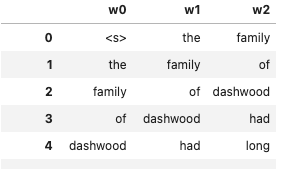

Note how each succussive column is the same data but shifted up one row.

Note also that this table contains all the data required to count instances of trigrams and all lower-order n-grams, i.e. bigram and unigram.

## Prepare tokens for ngram binding

We assign an absolute sentence number to each inital token and then label all the tokens in a given sentence by their sentence number.

We must do this because the current `sent_num` index column refers to the order of the sentence within the paragraph.

We want the order of the sentence within the corpus.

In [23]:

def token_to_padded(token, grouper=['sent_num'], term_str='term_str'):
    ohco = token.index.names # We preserve these since they get lost in the shuffle
    print(ohco)
    padded = token.groupby(grouper)\
        .apply(lambda x: '<s> ' + ' '.join(x[term_str]) + ' </s>')\
        .apply(lambda x: pd.Series(x.split()))\
        .stack().to_frame('term_str')
    print(padded)
    print(ohco)
    padded.index.names = ohco 
    return padded

In [24]:
PADDED = token_to_padded(TOKEN, grouper=OHCO[:3], term_str='modified_term_str')

['chap_id', 'para_num', 'sent_num', 'token_num']
                                term_str
chap_id para_num sent_num               
1       0        0        0          <s>
                          1          the
                          2   publishers
                          3           of
                          4          the
...                                  ...
32      82       1        11          in
                          12    darkness
                          13         and
                          14    distance
                          15        </s>

[88801 rows x 1 columns]
['chap_id', 'para_num', 'sent_num', 'token_num']


In [25]:
PADDED

term_str
chap_id para_num sent_num token_num            
1       0        0        0                 <s>
                          1                 the
                          2          publishers
                          3                  of
                          4                 the
...                                         ...
32      82       1        11                 in
                          12           darkness
                          13                and
                          14           distance
                          15               </s>

[88801 rows x 1 columns]

## Bind modified token sequence into an ngram table 

Next, we choose the maximum ngram length for our models.

Now we concatenate a set of offset versions of our token list. 

We use the `df.shift()` method to offset our token list for each position in the resulting ngram list.

Then we use the `pd.concat()` method to bind our offset token lists.

In [26]:
# T = PADDED.groupby(OHCO[:4]).apply(lambda x: pd.concat([x.shift(0-i) for i in range(ngrams)], axis=1)).reset_index(drop=True)
# T.index = PADDED.index
# T.columns = widx

In [27]:
# T.loc[(1,1,0,2)]

In [28]:
def padded_to_ngrams(padded, grouper=['sent_num'], n=2):
    
    ohco = padded.index.names
    ngrams = padded.groupby(grouper)\
        .apply(lambda x: pd.concat([x.shift(0-i) for i in range(n)], axis=1))\
        .reset_index(drop=True)
    ngrams.index = padded.index
    ngrams.columns = widx

    # ngrams = pd.concat([padded.shift(0-i) for i in range(n)], axis=1)
    # ngrams.index.name = 'ngram_num'
    # ngrams.columns = widx
    # ngrams = ngrams.fillna('<EOF>')
    
    return ngrams

In [29]:
NGRAMS = padded_to_ngrams(PADDED, OHCO[:3], ngrams)

In [31]:
NGRAMS

w0          w1          w2
chap_id para_num sent_num token_num                                    
1       0        0        0                 <s>         the  publishers
                          1                 the  publishers          of
                          2          publishers          of         the
                          3                  of         the    standard
                          4                 the    standard      novels
...                                         ...         ...         ...
32      82       1        11                 in    darkness         and
                          12           darkness         and    distance
                          13                and    distance        </s>
                          14           distance        </s>        None
                          15               </s>        None        None

[88801 rows x 3 columns]

## Generate models

Next we create a list of models. 

Since the model index will be zero-based (given Python), the trigram model will be `M[2]`, for example. 

We can use the maximum ngram table to derive all of the lower order models.

For each model, we will compute the relevant probabilities and information for each ngram.

In [32]:
def ngrams_to_models(ngrams):
    global widx
    n = len(ngrams.columns)
    model = [None for i in range(n)]
    for i in range(n):
        if i == 0:
            model[i] = ngrams.value_counts('w0').to_frame('n')
            model[i]['p'] = model[i].n / model[i].n.sum()
            model[i]['i'] = np.log2(1/model[i].p)
        else:
            model[i] = ngrams.value_counts(widx[:i+1]).to_frame('n')    
            model[i]['cp'] = model[i].n / model[i-1].n
            model[i]['i'] = np.log2(1/model[i].cp)
        model[i] = model[i].sort_index()
    return model

In [33]:
M = ngrams_to_models(NGRAMS)

In [67]:
M[2]

n   cp    i
w0       w1      w2                       
11th     17      </s>          1  1.0  0.0
         the     passage       1  1.0  0.0
12th     17      </s>          1  1.0  0.0
13th     17      </s>          1  1.0  0.0
1816     in      the           1  1.0  0.0
...                           ..  ...  ...
youthful lovers  while         1  0.5  1.0
youths   cradled in            1  1.0  0.0
zeal     modern  philosophers  1  1.0  0.0
         of      felix         1  0.5  1.0
                 his           1  0.5  1.0

[67171 rows x 3 columns]

In [129]:
stop = ['this', 'the', 'a', '<s>']
tmp = NGRAMS.query("w1=='monster'")
tmp2 = tmp[~tmp['w0'].isin(['this', 'the', 'a', '<s>'])]
tmp2

w0       w1     w2
chap_id para_num sent_num token_num                            
13      3        17       25          miserable  monster   whom
18      8        0        1            abhorred  monster   </s>
23      25       4        23         detestable  monster   </s>
24      28       0        1             hideous  monster   </s>
32      4        9        5             hellish  monster  drink
        17       6        2            gigantic  monster   they

# Test Models

## Generate Training Data

Import and pad the test sentences.

In [136]:
S= "The monster is on the ice.\nFlowers are happy things.\nI have never seen the aurora borealis.\nHe never knew the love of a family."
S = S.split('\n')
S = pd.DataFrame(S, columns=['sent_str'])
S.index.name='sent_num'

# Convert dataframe of sentences to TOKEN with normalized terms
K = S.sent_str.apply(lambda x: pd.Series(x.split())).stack().to_frame('token_str')
K['term_str'] = K.token_str.str.replace(r"[\W_]+", "", regex=True).str.lower()
K.index.names = ['sent_num', 'token_num']

TEST_SENTS, TEST_TOKENS = S, K

## Identify OOV terms

Create a Series of OOV terms from our unigram model.

This could be included in our function.

In [139]:
TEST_TOKENS.loc[~TEST_TOKENS.term_str.isin(M[0].index), 'term_str'] = "<UNK>"

In [140]:
TEST_TOKENS[TEST_TOKENS.term_str == '<UNK>'].value_counts('token_str')

token_str
aurora       1
borealis.    1
Name: count, dtype: int64

## Convert test tokens into ngrams

Use offset and bind method using `pd.concat()` and `df.shift(0)`, as above.

In [141]:
TEST_PADDED = token_to_padded(TEST_TOKENS)

['sent_num', 'token_num']
           term_str
sent_num           
0        0      <s>
         1      the
         2  monster
         3       is
         4       on
         5      the
         6      ice
         7     </s>
1        0      <s>
         1  flowers
         2      are
         3    happy
         4   things
         5     </s>
2        0      <s>
         1        i
         2     have
         3    never
         4     seen
         5      the
         6    <UNK>
         7    <UNK>
         8     </s>
3        0      <s>
         1       he
         2    never
         3     knew
         4      the
         5     love
         6       of
         7        a
         8   family
         9     </s>
['sent_num', 'token_num']


In [169]:
TEST_PADDED

term_str
sent_num token_num         
0        0              <s>
         1              the
         2          monster
         3               is
         4               on
         5              the
         6              ice
         7             </s>
1        0              <s>
         1          flowers
         2              are
         3            happy
         4           things
         5             </s>
2        0              <s>
         1                i
         2             have
         3            never
         4             seen
         5              the
         6            <UNK>
         7            <UNK>
         8             </s>
3        0              <s>
         1               he
         2            never
         3             knew
         4              the
         5             love
         6               of
         7                a
         8           family
         9             </s>

In [194]:
TEST_NGRAMS = padded_to_ngrams(TEST_PADDED, 'sent_num', 2)

ValueError: Length mismatch: Expected axis has 2 elements, new values have 3 elements

In [178]:
TEST_NGRAMS.loc[0]

,w0,w1,w2
token_num,,,
0,<s>,the,monster
1,the,monster,is
2,monster,is,on
3,is,on,the
4,on,the,ice
5,the,ice,</s>
6,ice,</s>,None
7,</s>,None,None


## Bind the models to test data

We add our model data to the test data as a set of features.

In [145]:
def test_model(model, ngrams, sents):
    
    global widx
    
    assert len(model) == len(ngrams.columns)
    
    n = len(model)
    ohco = ngrams.index.names
    
    R = []
    for i in range(n):
        T = ngrams.merge(M[i], on=widx[:i+1], how='left')
        T.index = ngrams.index
        T = T.reset_index().set_index(ohco + widx).i #.to_frame(f"i{i}")
        
        # This how we handle unseen combos
        T[T.isna()] = T.max()
        R.append(T.to_frame(f"i{i}"))
                
    return pd.concat(R, axis=1)

In [163]:
R = test_model(M,TEST_NGRAMS, TEST_SENTS)

In [191]:
def compute_perplexity(results, test_sents, n=3):
    for i in range(n):
        test_sents[f"pp{i}"] = np.exp2(results.groupby('sent_num')[f"i{i}"].mean())
    return test_sents

In [192]:
PP = compute_perplexity(R, TEST_SENTS)

In [193]:
PP

,sent_str,pp0,pp1,pp2
sent_num,,,,
0,The monster is on the ice.,116.931101,72.914436,71.439668
1,Flowers are happy things.,552.541874,358.229326,191.000000
2,I have never seen the aurora borealis.,299.843636,36.637991,83.712719
3,He never knew the love of a family.,171.859389,117.836895,67.550603


In [184]:
# T0 = TEST_NGRAMS.merge(M[0], on=['w0'], how='left')
# T0.index = TEST_NGRAMS.index
# TEST_SENTS['pp0'] = np.exp2(T0.groupby('sent_num').i.mean())

# T1 = TEST_NGRAMS.merge(M[1], on=['w0','w1'], how='left')
# T1.index = TEST_NGRAMS.index
# TEST_SENTS['pp1']= np.exp2(T1.groupby('sent_num').i.mean())

# T2 = TEST_NGRAMS.merge(M[2], on=['w0','w1','w2'], how='left')
# T2.index = TEST_NGRAMS.index
# TEST_SENTS['pp2']= np.exp2(T2.groupby('sent_num').ci.mean())

# Model Perplexity

In [58]:
# R.groupby('sent_num').mean().mean().plot.bar();

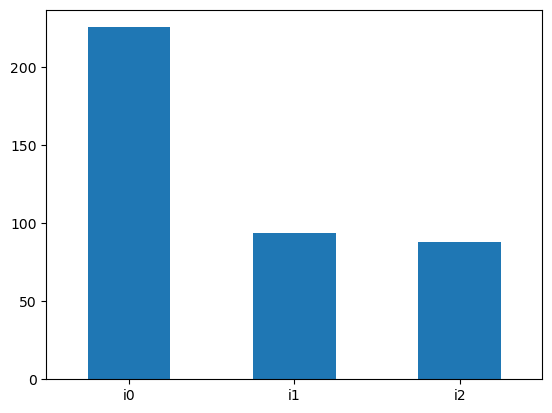

In [150]:
np.exp2(R.mean()).plot.bar(rot=0);

In [151]:
PP.iloc[:,1:].corr().style.background_gradient(axis=None)

,pp0,pp1,pp2
pp0,1.000000,0.836730,0.952253
pp1,0.836730,1.000000,0.941562
pp2,0.952253,0.941562,1.000000


In [61]:
# PP.iloc[:,1:].corr().unstack().sort_values(ascending=False).reset_index().query("level_0 < level_1").set_index(['level_0','level_1'])

# Visualize

In [152]:
Z = TEST_SENTS.copy()
Z['sent_str'] = Z.sent_str.str.replace('<s> ', '').str.replace(' </s>', '')
Z = Z.set_index('sent_str')
Z = (Z - Z.mean()) / Z.std()

In [153]:
Z['pp_mean'] = Z.mean(axis=1) # Just for sorting purposes

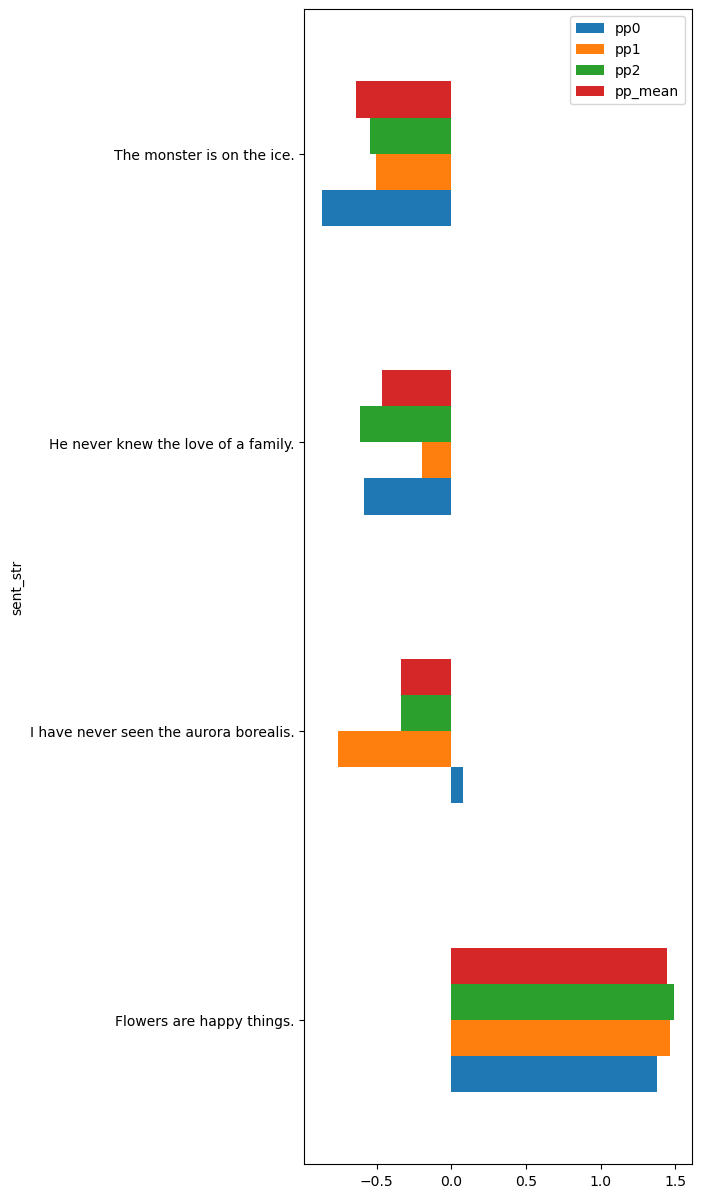

In [154]:
Z.sort_values('pp_mean', ascending=False).plot.barh(figsize=(5,15));

# Generate Text

In [158]:
def generate_text(M, n=250):
    
    if len(M) < 3:
        raise ValueError("Must have trigram model generated.")
    
    # Start list of words
    first_word = M[1].loc['<s>'].sample(weights='cp').index[0]
    
    words = ['<s>', first_word]
    
    for i in range(n):
        
        bg = tuple(words[-2:])

        # Try trigram model
        try:
            next_word = M[2].loc[bg].sample(weights='cp').index[0]

        # If not found in model, back off ...
        except KeyError as e1:
            try:
                # Get the last word in the bigram
                ug = bg[1]
                next_word = M[1].loc[ug].sample(weights='cp').index[0]
            
            except KeyError as e2:
                next_word = M[0].sample(weights='p').index[0]
                
        words.append(next_word)
    
    
    text = ' '.join(words[2:])
    print('\n\n'.join([str(i+1) + ' ' + line.replace('<s>','')\
        .strip().upper() for i, line in enumerate(text.split('</s>'))]))

In [159]:
generate_text(M)

1 MOUNTAINS

2 AN IDEA OF THE PISTOL BROUGHT A CROWD AND TO WHOM THOU ART

3 TO THEIR WARM FIRE SIDES

4 DEPARTURE AT LENGTH LASSITUDE SUCCEEDED TO YOUR DESTRUCTION AND TO DESTROY ALL THAT IS GIVEN TO SOME UNTRODDEN BRAKE THERE TO SUBDUE ME TO WRITE STORIES

5 I FOUND THAT I HAVE STRANGLED THE INNOCENT AS I ASCENDED A LOW HILL THAT BOUNDS PLAINPALAIS ON THE FIRST PLACE BE AFFORDED

6 THE LATTER METHOD OF COMMUNICATING THEIR EXPERIENCE AND FEELINGS TO DECIDE

7 I HASTENED THAT OF MY ADVERSARY

8 HIS SISTER FOR I CANNOT BELIEVE THAT HIS FORMER BENEVOLENCE

9 AT THAT MOMENT I KNEW IT

10 WHAT IS IT THAT YOU COME IF IT WERE BY SOME PAPERS IN THE HEAVENS

11 HARM HE PERFORMED THE KINDEST ACTION THAT HE CAN TELL THE DELIGHT OF CLERVAL

12 BEASTS OF THE WOMEN FAINTED

13 RAIN STILL CONTINUED AND THE ABANDONED AM AN UNFORTUNATE AND RECENT EVENTS

14 HAD TAKEN TO ENSURE MY HAVING A COMPANION FOR ONE WHERE THE CORPSE WAS AFTERWARDS FOUND

15 AFFECTION SHOULD YOU NEVER TO MAKE

16 ALLOW HIM TO TH